In [ ]:
# 

In [1]:
import os
import re
import json
import csv
import datetime
from langchain.prompts import PromptTemplate
from genai.credentials import Credentials
import os
from dotenv import load_dotenv
# Using Generative AI Library
from genai.model import Model
from genai.schemas import GenerateParams
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

## 1. Load data

This is an open source data set from https://www.kaggle.com/datasets/notlucasp/financial-news-headlines/

In [2]:
# read the csv file data/reuters_headlines.csv into a dataframe
df = pd.read_csv('data/reuters_headlines.csv',nrows=1000)
df.head()


,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...


In [3]:
df.describe()

,Headlines,Time,Description
count,1000,1000,1000
unique,996,20,996
top,Factbox: More companies join Facebook ad boyco...,Jul 16 2020,Ohio Attorney General Dave Yost said Tuesday t...
freq,3,93,2


## 2. setup connection to watsonx.ai

This is needed to access the hosted models within watsonx.ai via the API.

In [17]:
load_dotenv()
api_key = os.getenv("GENAI_KEY")
api_url = os.getenv("GENAI_API")

creds = Credentials(api_key, api_endpoint=api_url) # credentials object to access the LLM service

In [18]:
# a helper function to generate text
def get_completion(sample, prompt_string, model):
    prompt_template = PromptTemplate.from_template(prompt_string)
    prompt=prompt_template.format(sample=sample)
    result=model.generate([prompt])[0].generated_text
    return result

# 3. get sentiment

This is the first aspect that we are extracting from the raw data

In [6]:
# define model type
#MODELTYPE = "meta-llama/llama-2-70b-chat"
MODELTYPE = "ibm/granite-13b-chat-v1"
# MODELTYPE = "ibm/granite-13b-sft"


# Instantiate parameters for text generation
params = GenerateParams(
    decoding_method="sample", # use 'greedy' alternatively
    max_new_tokens=1000,
    min_new_tokens=1,
    temperature=0.5,
    repetition_penalty=1.2,
    top_k=50,
    top_p=1,
)

# Instantiate a model proxy object to send your requests
granite_13_chat_model = Model(MODELTYPE, params=params, credentials=creds)

In [7]:
prompt_string_sentiment_analysis="""
Analyze the sentiment of the following financial article.Determine whether the sentiment is positive, negative, or neutral. Answer with only one word!: 

financial article:
"{sample}" 

sentiment:
"""

go through all cells of the dataset and get the sentiment for each cell. This is highly parallelized.

In [8]:
import concurrent.futures

def process_row_sentiment(index, row):
    sentiment = get_completion(row['Description'], prompt_string_sentiment_analysis, granite_13_chat_model)
    return index, sentiment

# Assuming df is your DataFrame
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Creating a list of futures
    futures = [executor.submit(process_row_sentiment, i, row) for i, row in df.iterrows()]

    # Retrieving results and updating the DataFrame
    for future in concurrent.futures.as_completed(futures):
        index, sentiment = future.result()
        df.at[index, 'sentiment'] = sentiment


In [10]:
df.head()

,Headlines,Time,Description,sentiment
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,positive
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,negative
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,negative
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,negative
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,positive


# 2. Extract named entities

In [12]:


# Instantiate parameters for text generation
params = GenerateParams(
    decoding_method="greedy", # use 'greedy' alternatively
    # max_new_tokens=1000,
    # min_new_tokens=1,
    # temperature=0.5,
    # repetition_penalty=1.2,
    # top_k=50,
    # top_p=1,
)

# Instantiate a model proxy object to send your requests

# llama 2 --> 100 rows = 180 seconds --> 1 row = 1.8 seconds --> 30000 rows = 54000 seconds = 15 hours
llame_2_70b_model = Model("meta-llama/llama-2-70b-chat", params=params, credentials=creds)
# granite-13b-instruct-v1 --> 100 rows = 90 seconds --> 1 row = 0.9 seconds --> 30000 rows = 27000 seconds = 7.5 hours
granite_13_instruct_model = Model("ibm/granite-13b-instruct-v1", params=params, credentials=creds)

In [13]:
prompt_string_named_entities="""
Act as a webmaster who must extract structured information from emails. Read the below email and extract and categorize each entity.


Input:
"Golden Bank is a competitor of Silver Bank in the US" said John Doe.

Output: (Named Entities)
Golden Bank: company, Silver Bank: company, US: country, John Doe: person

Input:
Alphabet Inc's Google said on Friday it would prohibit websites and apps that use its advertising technology from running ads on "dangerous content" that goes against scientific consensus during the coronavirus pandemic.

Output: (Named Entities)
Alphabet Inc: company,  Google: company division, Friday: day of the week, coronavirus pandemic: event

Input:
{sample}

Output: (Named Entities)
"""

In [15]:
import re

input_str = "TikTok: company, UK government: organization, London: location, China: country "

def parse_string_to_touple_list(input_str):
    # Regular expression pattern to match 'key: value' pairs
    # Adjust the pattern as needed to handle different formats
    pattern = r'(\w[\w\s]*?)\s*:\s*([\w\s]+)'

    # Find all matches and convert them to tuples
    tuples_list = re.findall(pattern, input_str)
    
    # remove any leading or trailing spaces as well as newlines from the keys and values
    tuples_list = [(key.strip(), value.strip()) for key, value in tuples_list]   
    
    return tuples_list



# Display the list of tuples
print(parse_string_to_touple_list(input_str))	

[('TikTok', 'company'), ('UK government', 'organization'), ('London', 'location'), ('China', 'country')]


In [ ]:
df_copy = df.copy()
# Initialize the 'named_entities' column with default values
df_copy['named_entities'] = [None] * len(df_copy)

for i in range(df_copy.shape[0]):
    named_entities=get_completion(df_copy['Description'][i], prompt_string_named_entities, granite_13_instruct_model)
    # parse the named_entities string into a list of tuples and store it in a new column called 'named_entities'
    df_copy['named_entities'][i] = parse_string_to_touple_list(named_entities)
    
df_copy.head(10)

In [18]:
df.head(10)

,Headlines,Time,Description,sentiment,named_entities
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,positive,NaN
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,negative,NaN
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,negative,NaN
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,negative,NaN
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,positive,NaN
5,Wall Street Week Ahead: Fund managers navigate...,Jul 17 2020,Investors are searching for bargains in the wo...,negative,NaN
6,Take Five: Hoping for that V-shape in earnings,Jul 17 2020,We knew Q2 earnings would be dire but the hope...,negative,NaN
7,Evictions nearly back to pre-pandemic levels i...,Jul 17 2020,Landlords in some areas of the United States a...,neutral,NaN
8,Google bans ads on coronavirus conspiracy theo...,Jul 17 2020,Alphabet Inc's Google said on Friday it would ...,positive,NaN
9,"Flight to suburbs boosts U.S. homebuilding, bu...",Jul 17 2020,U.S. homebuilding increased in June by the mos...,positive,NaN


In [19]:
import concurrent.futures

# Function to process each row
def process_row(index, row):
    named_entities = get_completion(row['Description'], prompt_string_named_entities, granite_13_instruct_model)
    return index, parse_string_to_touple_list(named_entities)

# Initialize the 'named_entities' column
df['named_entities'] = None

# Using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_row, i, row) for i, row in df.iterrows()]

    for future in concurrent.futures.as_completed(futures):
        index, named_entities = future.result()
        df.at[index, 'named_entities'] = named_entities



In [23]:
# serialize the dataframe to a csv file using timestamp as part of the name to avoid overwriting
# now = datetime.datetime.now()
# timestamp = now.strftime("%Y%m%d_%H%M")
# df.to_csv(f'data/reuters_headlines_{timestamp}.csv', index=False)

def create_snapshot(df):
    now = datetime.datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M")
    df.to_csv(f'data/reuters_headlines_{timestamp}.csv', index=False)

### snapshot utils!

In [54]:
import glob
import ast

# load the latest csv backup file into a dataframe
def get_latest_csv_file_path():
    list_of_files = glob.glob('data/reuters_headlines_*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

def load_latest_snapshot_from_csv():
    df = pd.read_csv(get_latest_csv_file_path())
    df['named_entities'] = df['named_entities'].apply(ast.literal_eval)
    return df

df = load_latest_snapshot_from_csv()
df.head()

,Headlines,Time,Description,sentiment,named_entities,key_action
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,positive,"[(TikTok, company), (UK, country), (headquarte...",Locate headquarters
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,negative,"[(Walt Disney, company), (Facebook Inc, company)]",Slash advertising
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,negative,"[(Jan Marsalek, person), (Wirecard, company)]",Travelled to Minsk
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,negative,"[(Twitter Inc, company), (hackers, person), (a...",Download account information
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,positive,"[(Congress, legislative body), (coronavirus, d...",Granting liability prote


In [12]:
# get all company names from the named_entities column
company_names = df['named_entities'].apply(
    lambda x: [tuple[0] for tuple in x if tuple[1] == 'company'] if x is not None else []
)
company_names.head(40)

0                            [TikTok]
1         [Walt Disney, Facebook Inc]
2                          [Wirecard]
3                       [Twitter Inc]
4                                  []
5                                  []
6                                  []
7                                  []
8                      [Alphabet Inc]
9                                  []
10                  [Delta Air Lines]
11                                 []
12                     [Facebook Inc]
13                                 []
14                    [BlackRock Inc]
15                                 []
16                 [Boohoo Group Plc]
17                          [Moderna]
18              [Petroleos Mexicanos]
19                      [Twitter Inc]
20                                 []
21                                 []
22                                 []
23                                 []
24                                 []
25                                 []
26         [

In [13]:

# get the most common company names
from collections import Counter
company_names = Counter([item for sublist in company_names for item in sublist])
company_names.most_common(10)

[('Huawei', 24),
 ('Wirecard', 22),
 ('Airbus', 14),
 ('Tesla Inc', 13),
 ('Facebook Inc', 12),
 ('Apple', 12),
 ('Google', 11),
 ('Alphabet Inc', 10),
 ('Apple Inc', 10),
 ('Facebook', 10)]

## extract key actions

In [14]:
prompt_string_key_actions="""
You are the assistant of a fond manager. To help your boss you create super short summaries of financial news headlines called "key actions". Those key actions are no more than 3 words. Here are a few examples

Input:
TikTok considers London and other locations for headquarters,Jul 18 2020,"TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership
Output (2-3 words keyaction):
Locate headquarters

Input:
Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,"Walt Disney  has become the latest company to slash its advertising spending on Facebook Inc  as the social media giant faces an ad boycott over its handling of hate speech and controversial content, the Wall Street Journal reported on Saturday, citing people familiar with the situation."
Output (2-3 words keyaction):
Slash advertising

Input:
Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,Twitter Inc said on Saturday that hackers were able to download account information for up to eight accounts involved in the hack of its systems this week, but said none of them were verified accounts.
Output (2-3 words keyaction):
Hackers downloaded data

Input:
U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans were putting the finishing touches on provisions granting liability protections for a wide range of entities resuming operations amid the pandemic.
Output (2-3 words keyaction):
Seek liability protections

Input:
Senator asks Twitter about claim worker was paid to help with hack,Jul 17 2020,"Senator Josh Hawley, a Republican who closely follows tech issues, pressed Twitter Chief Executive Jack Dorsey on Friday on whether a company employee had been paid to assist with a hack of high-profile accounts this week aimed at scamming readers."
Output (2-3 words keyaction):
Senator asks

Now you do it:

Input:
{sample}

Output (2-3 words keyaction):
"""

In [20]:
# Instantiate parameters for text generation
params = GenerateParams(
    decoding_method="greedy", # use 'greedy' alternatively
    max_new_tokens=6,
    stop_sequences= ["\n"]
    # min_new_tokens=1,
    # temperature=0.5,
    # repetition_penalty=1.2,
    # top_k=50,
    # top_p=1,
)

# Instantiate a model proxy object to send your requests

# llama 2 --> 100 rows = 180 seconds --> 1 row = 1.8 seconds --> 30000 rows = 54000 seconds = 15 hours
llame_2_70b_model_key_actions = Model("meta-llama/llama-2-70b-chat", params=params, credentials=creds)
# granite-13b-instruct-v1 --> 100 rows = 90 seconds --> 1 row = 0.9 seconds --> 30000 rows = 27000 seconds = 7.5 hours
# granite_13_instruct_model = Model("ibm/granite-13b-instruct-v1", params=params, credentials=creds)

In [21]:
df_copy = df.copy()
# Initialize the 'named_entities' column with default values
df_copy['key_action'] = [None] * len(df_copy)

for i in range(df.shape[0]):
    key_action=get_completion(df['Description'][i], prompt_string_key_actions, llame_2_70b_model_key_actions)
    print(key_action)
    # remove newlines and trailing spaces
    key_action = key_action.replace('\n', '').strip()
    df['key_action'][i] = key_action
    
df_copy.head(10)

Locate headquarters

Slash advertising

Travelled to Minsk
Download account information

Granting liability prote
Searching for bargains
Slump 50%
File eviction cases

Prohibit dangerous ads
Increased homebuilding



,Headlines,Time,Description,sentiment,named_entities,key_action
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,positive,"[(TikTok, company), (UK, country), (headquarte...",Locate headquarters\n
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,negative,"[(Walt Disney, company), (Facebook Inc, company)]",Slash advertising\n
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,negative,"[(Jan Marsalek, person), (Wirecard, company)]",Travelled to Minsk
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,negative,"[(Twitter Inc, company), (hackers, person), (a...",Download account information\n
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,positive,"[(Congress, legislative body), (coronavirus, d...",Granting liability prote
5,Wall Street Week Ahead: Fund managers navigate...,Jul 17 2020,Investors are searching for bargains in the wo...,negative,"[(Investors, group), (caps, asset class)]",Searching for bargains
6,Take Five: Hoping for that V-shape in earnings,Jul 17 2020,We knew Q2 earnings would be dire but the hope...,negative,"[(Q2, quarter), (earnings, financial performan...",Slump 50%
7,Evictions nearly back to pre-pandemic levels i...,Jul 17 2020,Landlords in some areas of the United States a...,neutral,"[(Landlords, people), (areas, places), (United...",File eviction cases\n
8,Google bans ads on coronavirus conspiracy theo...,Jul 17 2020,Alphabet Inc's Google said on Friday it would ...,positive,"[(Alphabet Inc, company), (Google, company div...",Prohibit dangerous ads
9,"Flight to suburbs boosts U.S. homebuilding, bu...",Jul 17 2020,U.S. homebuilding increased in June by the mos...,positive,"[(homebuilding, economic indicator), (June, mo...",Increased homebuilding\n


In [22]:
import concurrent.futures

def process_row(index, row):
    # Extracting key actions
    key_action = get_completion(row['Description'], prompt_string_key_actions, llame_2_70b_model_key_actions)
    
    # Cleaning the key action string
    key_action = key_action.replace('\n', '').strip()
    
    return index, key_action

# Assuming df is your original DataFrame
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Creating a list of futures for each row in the DataFrame
    futures = [executor.submit(process_row, i, row) for i, row in df.iterrows()]

    # Retrieving results and updating the DataFrame
    for future in concurrent.futures.as_completed(futures):
        index, key_action = future.result()
        df.at[index, 'key_action'] = key_action


In [24]:
create_snapshot(df)

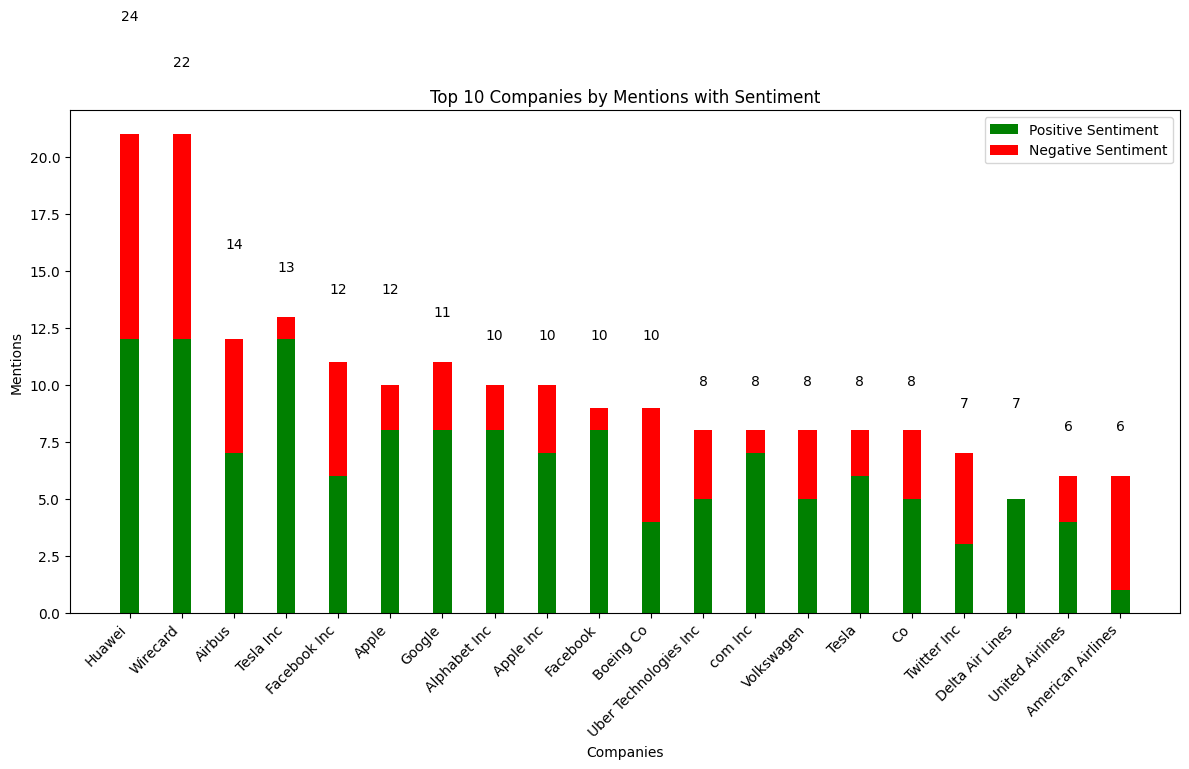

In [30]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
from collections import Counter

# Load the provided CSV file
file_path = get_latest_csv_file_path()  # Replace with your file path
df = pd.read_csv(file_path)

# Function to extract company names from the named_entities column
def extract_companies(named_entities):
    entities = literal_eval(named_entities)
    return [entity[0] for entity in entities if entity[1] == 'company']

# Apply the function to extract company names
df['companies'] = df['named_entities'].apply(extract_companies)

# Flatten the list of companies and count occurrences
all_companies = [company for sublist in df['companies'] for company in sublist]
company_count = Counter(all_companies)

# Prepare data for positive and negative sentiment counts
positive_counts = Counter([company for sublist in df[df['sentiment'] == 'positive']['companies'] for company in sublist])
negative_counts = Counter([company for sublist in df[df['sentiment'] == 'negative']['companies'] for company in sublist])

# Select top N companies for visualization
top_n = 20
top_companies = company_count.most_common(top_n)

# Prepare data for plotting
companies = [company[0] for company in top_companies]
total_counts = [company[1] for company in top_companies]
pos_counts = [positive_counts[company] for company in companies]
neg_counts = [negative_counts[company] for company in companies]

# Plotting
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = range(len(companies))

bar1 = plt.bar(index, pos_counts, bar_width, label='Positive Sentiment', color='green')
bar2 = plt.bar(index, neg_counts, bar_width, label='Negative Sentiment', color='red', bottom=pos_counts)

plt.xlabel('Companies')
plt.ylabel('Mentions')
plt.title('Top 10 Companies by Mentions with Sentiment')
plt.xticks(index, companies, rotation=45, ha="right")
plt.legend()

# Add total counts as text above bars
for i in range(len(companies)):
    plt.text(i, total_counts[i] + 2, str(total_counts[i]), ha = 'center')

plt.tight_layout()
plt.show()



In [ ]:
from collections import Counter
company_names = Counter([item for sublist in company_names for item in sublist])
company_names.most_common(10)

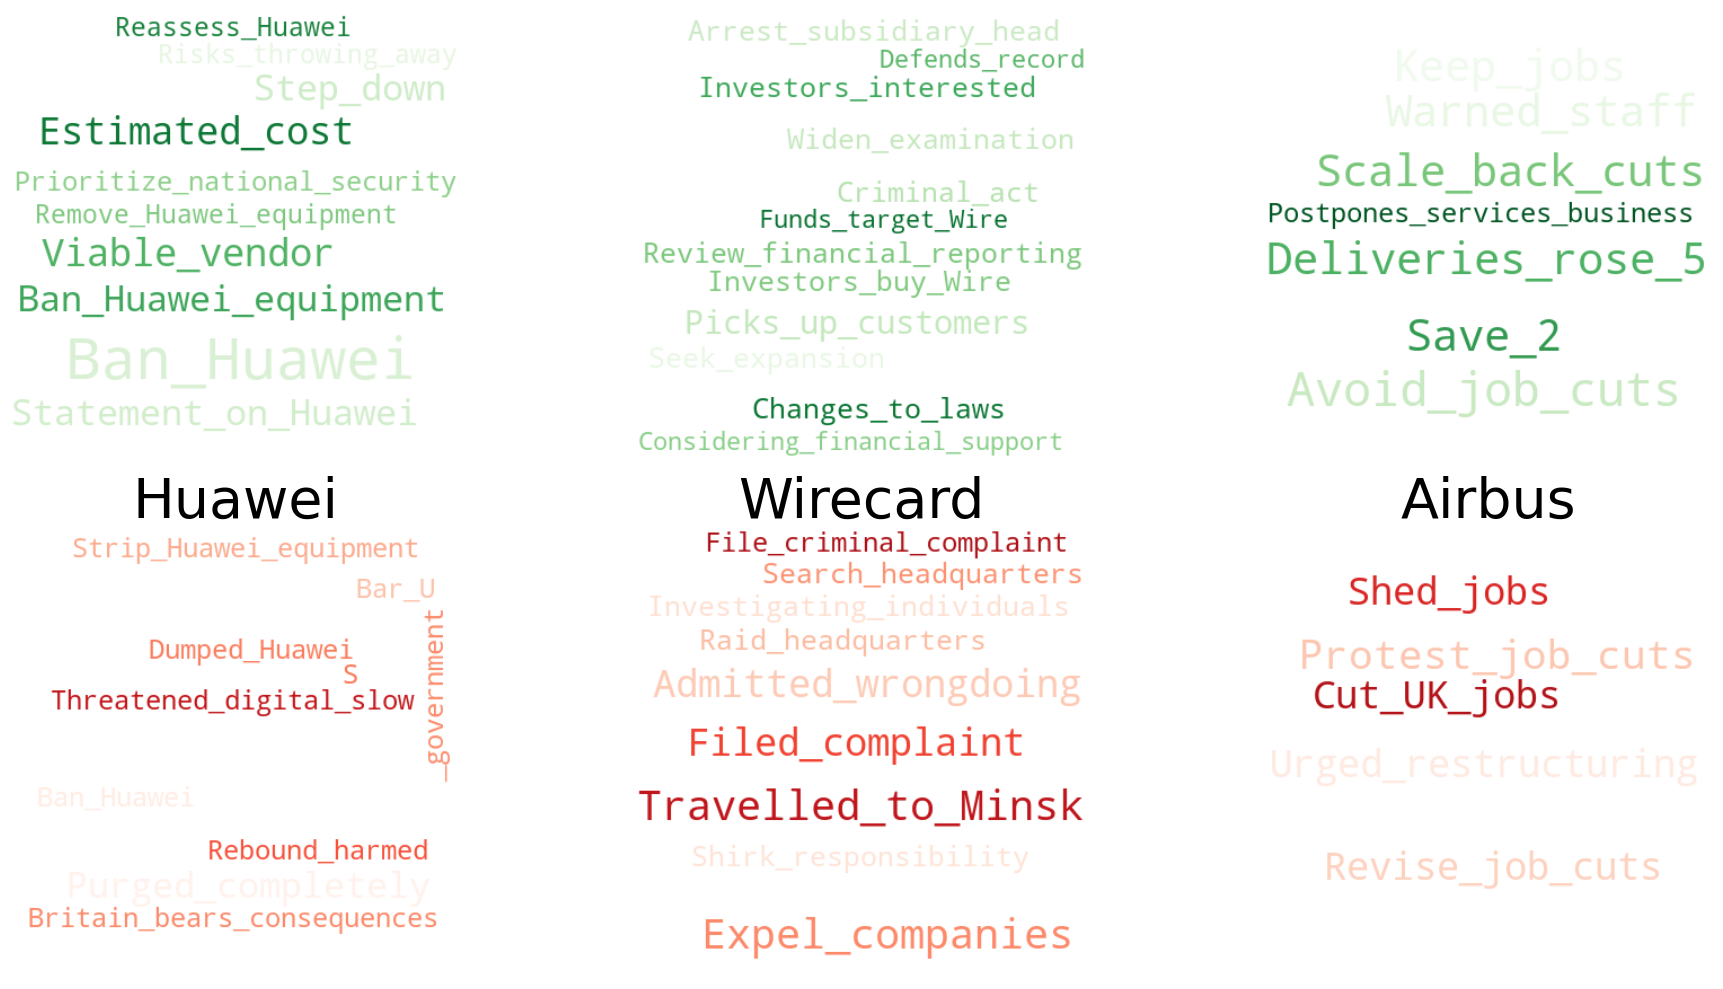

In [47]:
import pandas as pd
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the provided CSV file
file_path = get_latest_csv_file_path()  # Replace with your file path
df = pd.read_csv(file_path)

# Function to extract company names from the named_entities column
def extract_companies(named_entities):
    entities = literal_eval(named_entities)
    return [entity[0] for entity in entities if entity[1] == 'company']

# Apply the function to extract company names
df['companies'] = df['named_entities'].apply(extract_companies)

# Flatten the list of companies and count occurrences
all_companies = [company for sublist in df['companies'] for company in sublist]
company_count = Counter(all_companies)

# Select top 3 companies for visualization
top_3_companies = [company[0] for company in company_count.most_common(3)]

# Filter dataframe for positive and negative sentiments
positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']

# Function to prepare word cloud data keeping key actions intact
def prepare_wordcloud_data(df):
    # Replace spaces within key actions with underscores
    modified_key_actions = df['key_action'].str.replace(' ', '_')
    # Join the modified key actions with a newline
    return ' \n '.join(modified_key_actions.tolist())


# Preparing word cloud data for positive and negative sentiments for each company
wordcloud_data = {}
for company in top_3_companies:
    pos_data = prepare_wordcloud_data(positive_df[positive_df['companies'].apply(lambda x: company in x)])
    neg_data = prepare_wordcloud_data(negative_df[negative_df['companies'].apply(lambda x: company in x)])
    wordcloud_data[company] = {'positive': pos_data, 'negative': neg_data}

# Creating and displaying word clouds
plt.figure(figsize=(20, 10))

for i, company in enumerate(top_3_companies, 1):
    # Positive WordCloud
    plt.subplot(2, 3, i)
    pos_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Greens', collocations=False).generate(wordcloud_data[company]['positive'])
    plt.imshow(pos_wordcloud, interpolation='bilinear')
    # plt.title(f'{company} - Positive Actions', fontsize=60)
    plt.axis("off")

    # Negative WordCloud
    plt.subplot(2, 3, i + 3)
    neg_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Reds', collocations=False).generate(wordcloud_data[company]['negative'])
    plt.imshow(neg_wordcloud, interpolation='bilinear')
    plt.title(company, fontsize=40)
    plt.axis("off")

plt.tight_layout()
plt.show() 


In [60]:
top_3_companies

['Huawei', 'Wirecard', 'Airbus']

In [69]:
pd.set_option('display.max_colwidth', 100)  # Adjust the number as needed


In [70]:
df.head()

,Headlines,Time,Description,sentiment,named_entities,key_action
0,TikTok considers London and other locations for headquarters,Jul 18 2020,TikTok has been in discussions with the UK government over the past few months to locate its hea...,positive,"[(TikTok, company), (UK, country), (headquarters, location)]",Locate headquarters
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as...,negative,"[(Walt Disney, company), (Facebook Inc, company)]",Slash advertising
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports",Jul 18 2020,Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspe...,negative,"[(Jan Marsalek, person), (Wirecard, company)]",Travelled to Minsk
3,Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,Twitter Inc said on Saturday that hackers were able to download account information for up to ei...,negative,"[(Twitter Inc, company), (hackers, person), (account information, data)]",Download account information
4,U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans wer...,positive,"[(Congress, legislative body), (coronavirus, disease), (aid bill, legislation)]",Granting liability prote


In [73]:
filtered_df.describe()

,Headlines,Time,Description,sentiment,named_entities,key_action
count,1000,1000,1000,1000,1000,1000
unique,996,20,996,4,978,953
top,Factbox: More companies join Facebook ad boycott bandwagon,Jul 16 2020,Ohio Attorney General Dave Yost said Tuesday that General Motors Co should repay $60 million in ...,positive,"[(Luckin Coffee Inc, company), (Charles Zhengyao Lu, person)]",Cut jobs
freq,3,93,2,583,3,8


In [91]:
df=load_latest_snapshot_from_csv()
df["named_entities"]

companies_to_filter = ["TikTok","Walt Disney"]

df_filtered = pd.DataFrame(columns=df.columns)

for i in range(df.shape[0]):
    # print (df["named_entities"][i])
    for entities in df["named_entities"][i]:
        # print (entities[0])
        if entities[0] in companies_to_filter:
            print ("found in " + str(i))
            # add this row to a new dataframe
            df_filtered = df_filtered.append(df.iloc[i])
            


found in 0


AttributeError: 'DataFrame' object has no attribute 'append'

In [92]:
df = load_latest_snapshot_from_csv()
companies_to_filter = ["TikTok", "Walt Disney"]

rows_to_add = []

for i in range(df.shape[0]):
    for entities in df["named_entities"][i]:
        if entities[0] in companies_to_filter:
            print("found in " + str(i))
            rows_to_add.append(df.iloc[i])

df_filtered = pd.concat(rows_to_add, axis=1).transpose()


found in 0
found in 1
found in 77
found in 260
found in 289
found in 393
found in 402
found in 483
found in 490
found in 521
found in 566
found in 582
found in 603
found in 625
found in 631
found in 851
found in 938
found in 945


In [94]:
df_filtered.head()

,Headlines,Time,Description,sentiment,named_entities,key_action
0,TikTok considers London and other locations for headquarters,Jul 18 2020,TikTok has been in discussions with the UK government over the past few months to locate its hea...,positive,"[(TikTok, company), (UK, country), (headquarters, location)]",Locate headquarters
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as...,negative,"[(Walt Disney, company), (Facebook Inc, company)]",Slash advertising
77,"TikTok expected to operate as a U.S. company, White House adviser says",Jul 16 2020,A top White House adviser said on Thursday that he expects TikTok to separate from its Chinese o...,positive,"[(TikTok, app), (Chinese, country), (United States, country), (American, adjective)]",Separate from China
260,India quizzing owners of banned Chinese apps over content and practices,Jul 14 2020,Chinese companies such as TikTok-owner ByteDance have been asked by India to answer 77 questions...,neutral,"[(TikTok, app), (ByteDance, company), (India, country)]",Answer questions
289,TikTok's U.S. users prepare for life without the video app,Jul 14 2020,"Ty Gibson, 20, of Greensboro, North Carolina, brushed off speculation last week on TikTok that h...",positive,"[(Ty Gibson, person), (TikTok, platform)]",Brushed off speculation


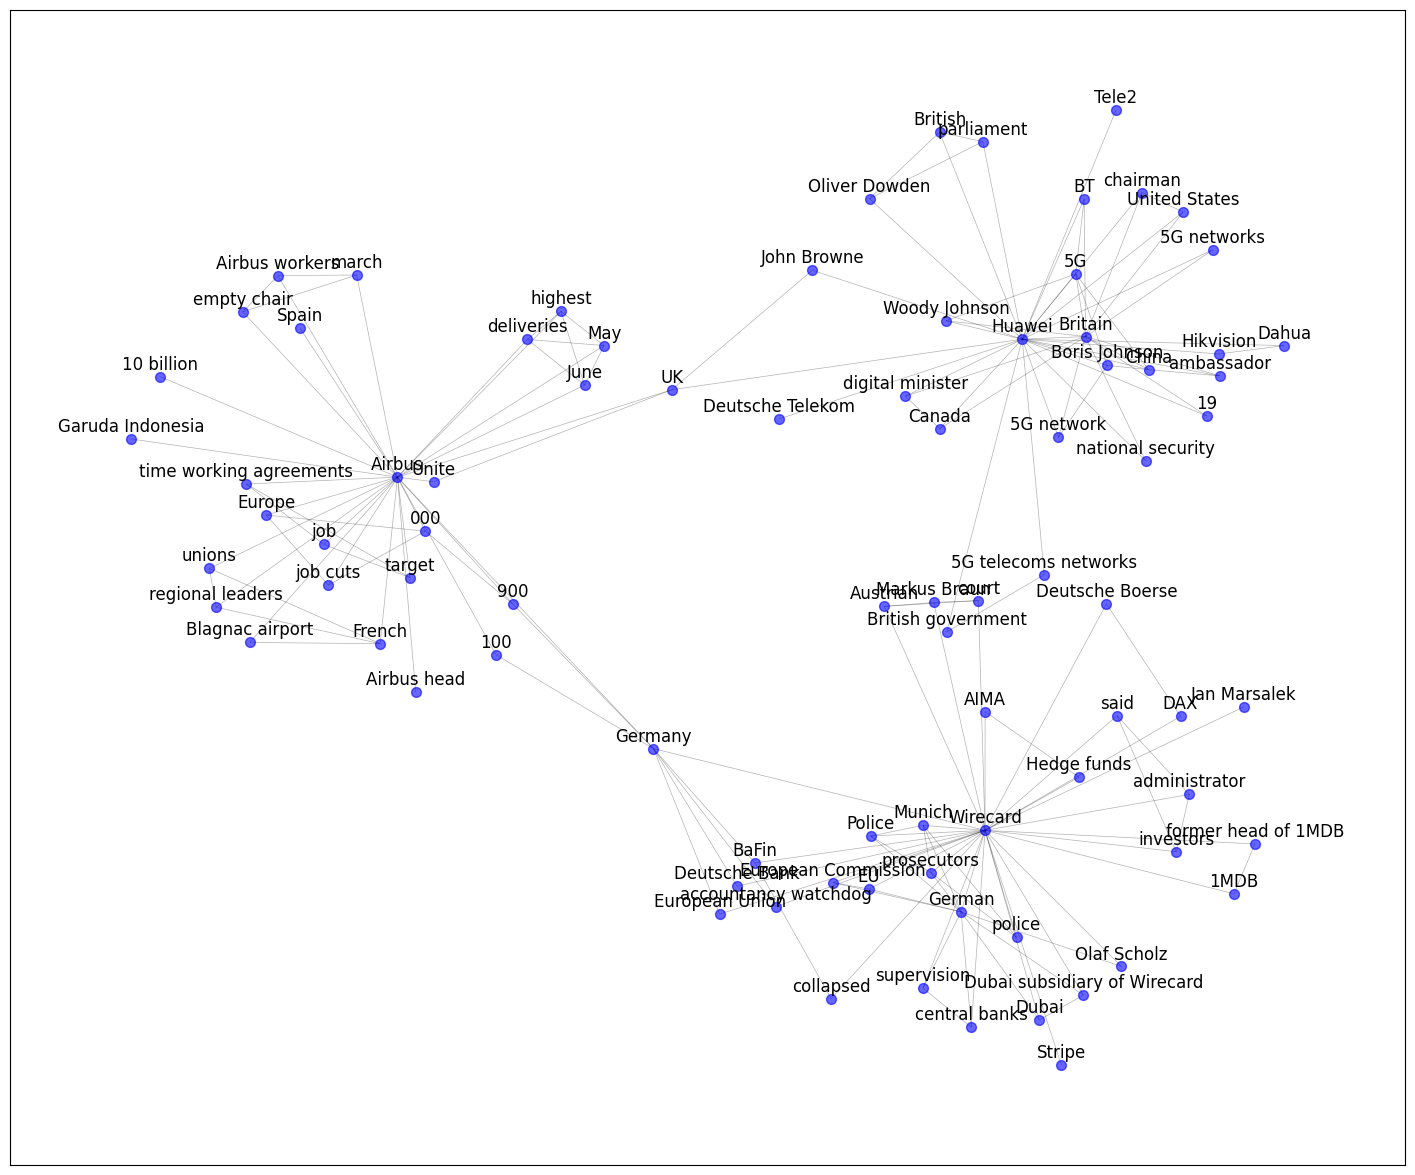

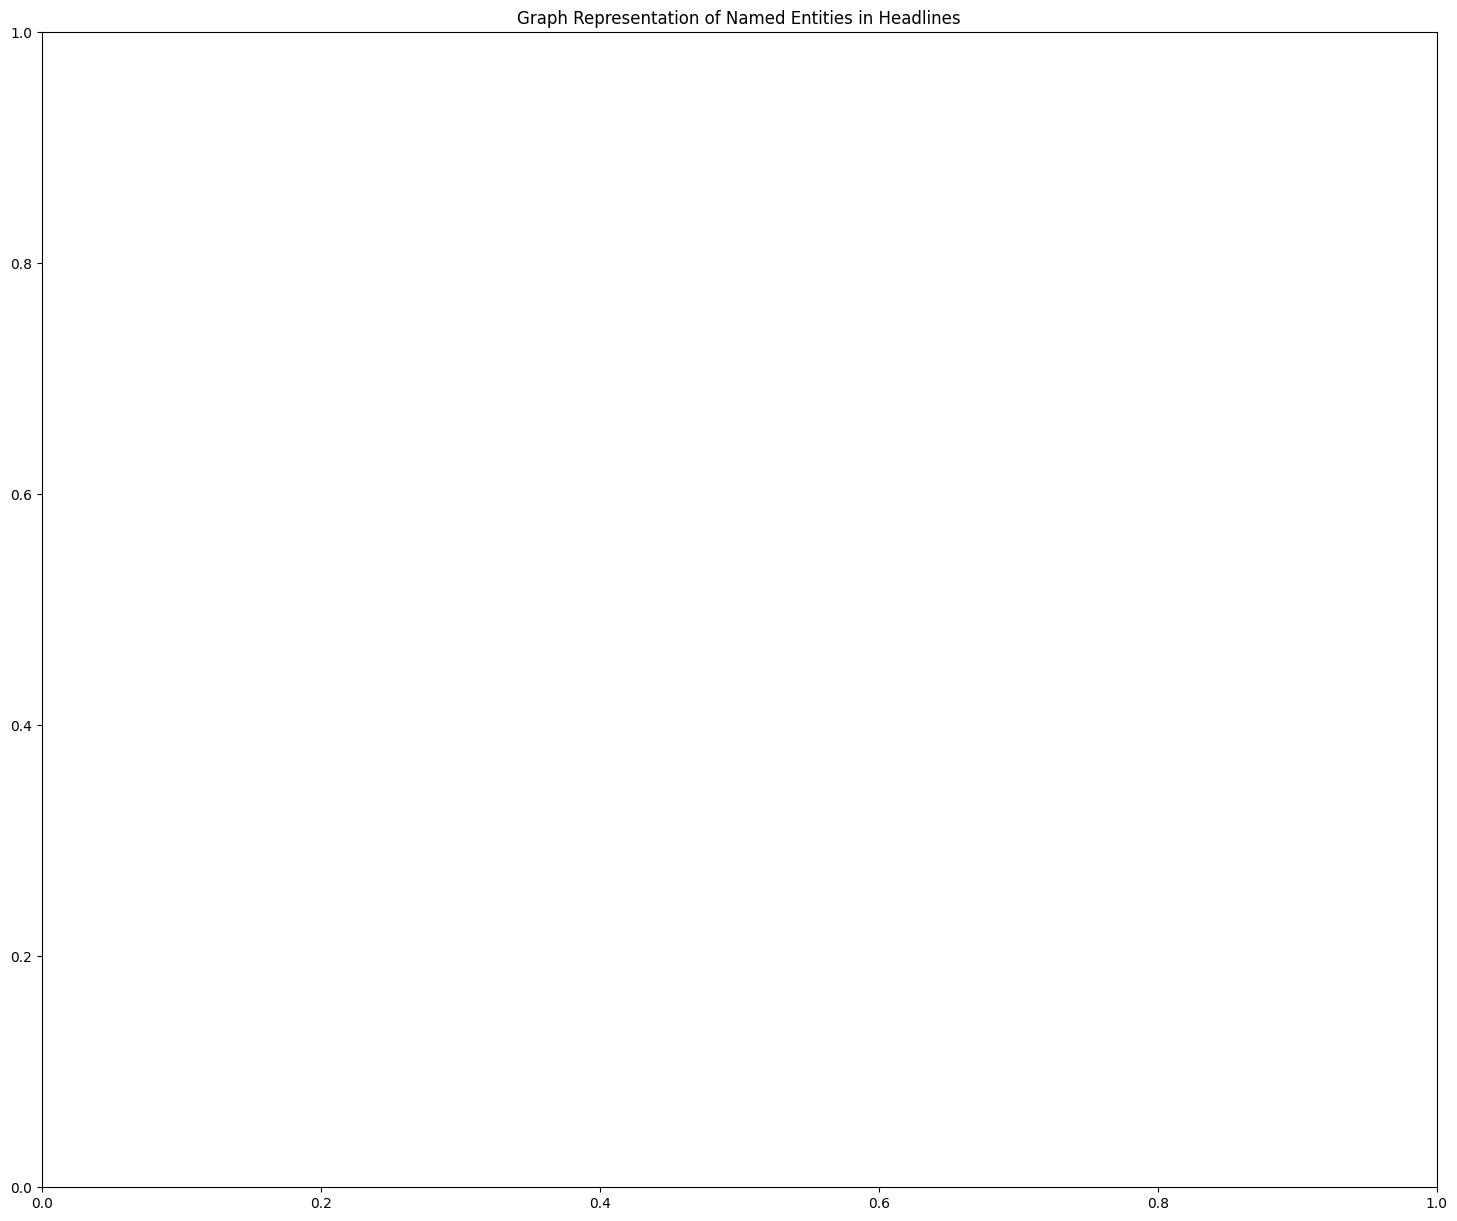

In [100]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

df = load_latest_snapshot_from_csv()
companies_to_filter = top_3_companies

rows_to_add = []

for i in range(df.shape[0]):
    for entities in df["named_entities"][i]:
        if entities[0] in companies_to_filter:
            rows_to_add.append(df.iloc[i])

df_filtered = pd.concat(rows_to_add, axis=1).transpose()

# Initialize a graph
G = nx.Graph()

# Add nodes and edges to the graph
for entities in df_filtered['named_entities']:
    for i in range(len(entities)):
        G.add_node(entities[i][0])  # Add entity as node
        for j in range(i + 1, len(entities)):
            # Add an edge if another entity is in the same headline
            G.add_edge(entities[i][0], entities[j][0])
            
            
# nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8)
# Set the layout for our nodes.
pos = nx.spring_layout(G, k=0.15, iterations=20)
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}

# Plot the graph with adjusted node and font sizes and with labels offset to avoid overlap with nodes.
plt.figure(figsize=(18, 15))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="blue", alpha=0.6)
nx.draw_networkx_labels(G, label_pos, font_size=12, font_color='black')


# Plot the graph
plt.figure(figsize=(18, 15))
plt.title("Graph Representation of Named Entities in Headlines")
plt.show()


In [49]:
df.head()

,Headlines,Time,Description,sentiment,named_entities,key_action,companies,parsed_entities
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,positive,"[('TikTok', 'company'), ('UK', 'country'), ('h...",Locate headquarters,[TikTok],"[(TikTok, company), (UK, country), (headquarte..."
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,negative,"[('Walt Disney', 'company'), ('Facebook Inc', ...",Slash advertising,"[Walt Disney, Facebook Inc]","[(Walt Disney, company), (Facebook Inc, company)]"
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,negative,"[('Jan Marsalek', 'person'), ('Wirecard', 'com...",Travelled to Minsk,[Wirecard],"[(Jan Marsalek, person), (Wirecard, company)]"
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,negative,"[('Twitter Inc', 'company'), ('hackers', 'pers...",Download account information,[Twitter Inc],"[(Twitter Inc, company), (hackers, person), (a..."
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,positive,"[('Congress', 'legislative body'), ('coronavir...",Granting liability prote,[],"[(Congress, legislative body), (coronavirus, d..."


In [ ]:
# Identify the top 5 most common entity types
top_entity_types = [entity_type for entity_type, _ in entity_type_counts.most_common(5)]

# Filter entities based on the top entity types
filtered_entities = []
for entities in df['parsed_entities']:
    filtered_list = [entity for entity in entities if entity[1] in top_entity_types]
    filtered_entities.extend(filtered_list)

# Count the frequency of each entity (name, type)
filtered_entity_counts = Counter(filtered_entities)

# Select entities which are more frequent (to reduce graph complexity)
most_common_entities = [entity for entity, count in filtered_entity_counts.items() if count > 1]

# Reinitialize the graph with filtered data
G_filtered = nx.Graph()

# Add nodes and edges for most common entities
for entities in filtered_entities:
    for i in range(len(entities)):
        if entities[i] in most_common_entities:
            G_filtered.add_node(entities[i][0])  # Add entity as node
            for j in range(i + 1, len(entities)):
                if entities[j] in most_common_entities:
                    # Add an edge if another common entity is in the same headline
                    G_filtered.add_edge(entities[i][0], entities[j][0])

# Plot the filtered graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(G_filtered, with_labels=True, node_size=20, font
